# This notebook uses pytorch lightning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm
import pytorch_lightning as pl
import sys

import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

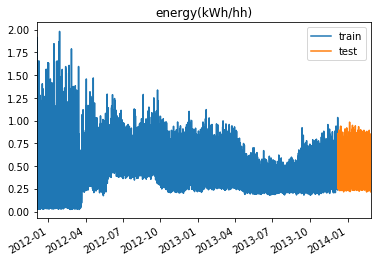

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

# Model

In [8]:
from pytorch_lightning import Trainer
from argparse import ArgumentParser  
from run_lightning_anp import add_default_args
from test_tube import HyperOptArgumentParser

parser = HyperOptArgumentParser(strategy='random_search', add_help=False)
parser = add_default_args(parser)
# give the module a chance to add own params
parser = LatentModelPL.add_model_specific_args(parser)



In [9]:
def parse_args(argv):
    # parse params
    # Set our params here, in a way compatible with cli
    argv = argv.replace('\n','').strip().split(' ')
    hyperparams = parser.parse_args(argv)

    import copy
    hparams = copy.deepcopy(hyperparams)
    for k in dir(hparams):
        if k.startswith('_'):
            continue
        v = getattr(hparams, k)
        if not isinstance(v, (int, float, str, bool, torch.Tensor)):
            delattr(hparams, k)


    return hyperparams, hparams

In [10]:
hyperparams, hparams = parse_args(f"""
--x_dim {df_train.shape[-1]-1} \
--y_dim 1 \
--grad_clip 40 \
""")
print(hparams)

----------------------------------------------------------------------------------------------------
Hyperparameters:
gpus                : -1
nodes               : 1
hpc_exp_number      : 1
seed                : 42
evaluate            : False
learning_rate       : 0.0001
batch_size          : 16
x_dim               : 16
y_dim               : 1
vis_i               : 670
hidden_dim          : 128
latent_dim          : 128
num_heads           : 8
attention_layers    : 1
n_latent_encoder_layers: 4
n_det_encoder_layers: 4
n_decoder_layers    : 2
dropout             : 0
attention_dropout   : 0
min_std             : 0.005
latent_enc_self_attn_type: multihead
det_enc_self_attn_type: multihead
det_enc_cross_attn_type: multihead
use_lvar            : False
use_deterministic_path: True
grad_clip           : 40.0
num_context         : 48
num_extra_target    : 24
max_nb_epochs       : 20
num_workers         : 4



# Hyperparam search

In [28]:
from test_tube import HyperOptArgumentParser
from run_lightning_anp import add_default_args
import os
import random


def main(hparams):
    if hparams.seed is not None:
        random.seed(hparams.seed)
        torch.manual_seed(hparams.seed)
        torch.backends.cudnn.deterministic = True
    print(hparams)
    # build model
    model = LatentModelPL(hparams)
    # configure trainer
    trainer = Trainer(
#         default_save_path=hparams.save_path,
        max_epochs=hparams.max_nb_epochs,
        gpus=hparams.gpus,
        gradient_clip_val=hparams.grad_clip,
#         track_grad_norm=1,
    )
    # train model
    if hparams.evaluate:
        trainer.run_evaluation()
    else:
        trainer.fit(model)
        
# use default args given by lightning
# root_dir = os.path.split(os.path.dirname(sys.modules['__main__'].__file__))[0]
root_dir = os.path.split(os.getcwd())[0]

parser = HyperOptArgumentParser(strategy='random_search', add_help=False)

parser = add_default_args(parser)

# allow model to overwrite or extend args
parser = LatentModelPL.add_model_specific_args(parser)

hyperparams = parser.parse_args([])

In [12]:
# # Run some trials on a single cpu. You can view them in tensorboard, and see the hyper params
# trials = hyperparams.generate_trials(16)
# for trial in tqdm(trials, desc='trials'):
#     try:
#         main(trial)
#     except KeyboardInterrupt:
#         break
#     except:
#         logging.exception("failed to run")

# Run

In [17]:
hyperparams, hparams = parse_args(f"""
--x_dim {df_train.shape[-1]-1} \
--y_dim 1 \
--grad_clip 40 \
--learning_rate 0.001 \
--latent_dim 16 \
--hidden_dim 128 \
--n_latent_encoder_layers 1 \
--n_det_encoder_layers 8 \
--n_decoder_layers 2 \
--use_lvar True \
--use_deterministic_path False \
--latent_enc_self_attn_type ptmultihead \
--det_enc_self_attn_type ptmultihead \
--det_enc_cross_attn_type ptmultihead \
--attention_layers 2 \
--attention_dropout 0.1 \
--dropout 0.2 \
""")
print(hparams)

----------------------------------------------------------------------------------------------------
Hyperparameters:
gpus                : -1
nodes               : 1
hpc_exp_number      : 1
seed                : 42
evaluate            : False
learning_rate       : 0.001
batch_size          : 16
x_dim               : 16
y_dim               : 1
vis_i               : 670
hidden_dim          : 128
latent_dim          : 16
num_heads           : 8
attention_layers    : 2
n_latent_encoder_layers: 1
n_det_encoder_layers: 8
n_decoder_layers    : 2
dropout             : 0
attention_dropout   : 0
min_std             : 0.005
latent_enc_self_attn_type: ptmultihead
det_enc_self_attn_type: ptmultihead
det_enc_cross_attn_type: ptmultihead
use_lvar            : True
use_deterministic_path: True
grad_clip           : 40.0
num_context         : 48
num_extra_target    : 24
max_nb_epochs       : 20
num_workers         : 4



INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                          Name           Type Params
0                                        model    LatentModel  827 K
1                        model._latent_encoder  LatentEncoder  204 K
2           model._latent_encoder._input_layer  NPBlockRelu2d    2 K
3    model._latent_encoder._input_layer.linear         Linear    2 K
4       model._latent_encoder._input_layer.act           ReLU    0  
..                                         ...            ...    ...
167              model._decoder._decoder.1.act           ReLU    0  
168          model._decoder._decoder.1.dropout      Dropout2d    0  
169             model._decoder._decoder.1.norm    BatchNorm2d  544  
170                       model._decoder._mean         Linear  273  
171                        model._decoder._std         Linear  273  

[172 rows x 3 columns]


step 0, {'val_loss': tensor(7609.9956, device='cuda:0'), 'val/kl': tensor(95.8767, device='cuda:0'), 'val/std': tensor(0.0047, device='cuda:0'), 'val/mse': tensor(0.3278, device='cuda:0')}


step 2201, {'val_loss': tensor(-1.4629, device='cuda:0'), 'val/kl': tensor(-0.4682, device='cuda:0'), 'val/std': tensor(0.1157, device='cuda:0'), 'val/mse': tensor(0.0087, device='cuda:0')}


step 4403, {'val_loss': tensor(-1.7365, device='cuda:0'), 'val/kl': tensor(-0.4962, device='cuda:0'), 'val/std': tensor(0.0880, device='cuda:0'), 'val/mse': tensor(0.0057, device='cuda:0')}


step 6605, {'val_loss': tensor(-1.7467, device='cuda:0'), 'val/kl': tensor(-0.5002, device='cuda:0'), 'val/std': tensor(0.0875, device='cuda:0'), 'val/mse': tensor(0.0055, device='cuda:0')}


step 8807, {'val_loss': tensor(-1.8249, device='cuda:0'), 'val/kl': tensor(-0.4795, device='cuda:0'), 'val/std': tensor(0.0798, device='cuda:0'), 'val/mse': tensor(0.0072, device='cuda:0')}


step 11009, {'val_loss': tensor(-1.8208, device='cuda:0'), 'val/kl': tensor(-0.4892, device='cuda:0'), 'val/std': tensor(5.1439e+21, device='cuda:0'), 'val/mse': tensor(0.0531, device='cuda:0')}


step 13211, {'val_loss': tensor(inf, device='cuda:0'), 'val/kl': tensor(-0.4811, device='cuda:0'), 'val/std': tensor(inf, device='cuda:0'), 'val/mse': tensor(0.1251, device='cuda:0')}


step 15413, {'val_loss': tensor(inf, device='cuda:0'), 'val/kl': tensor(-0.4861, device='cuda:0'), 'val/std': tensor(inf, device='cuda:0'), 'val/mse': tensor(0.1311, device='cuda:0')}
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.



1

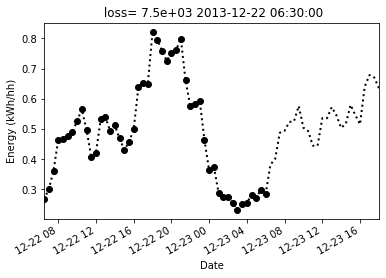

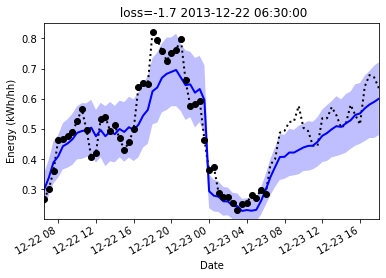

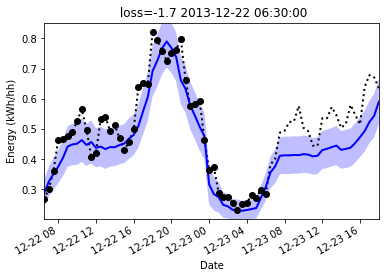

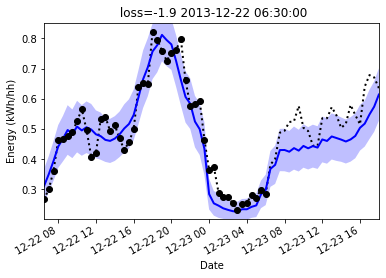

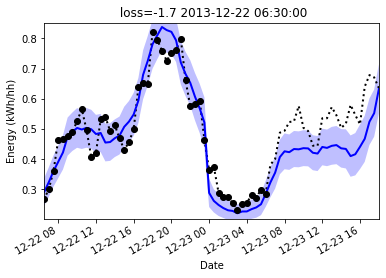

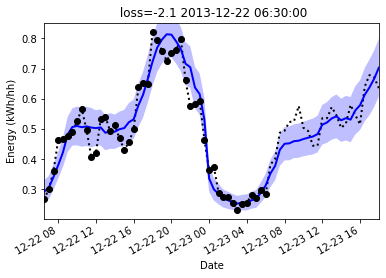

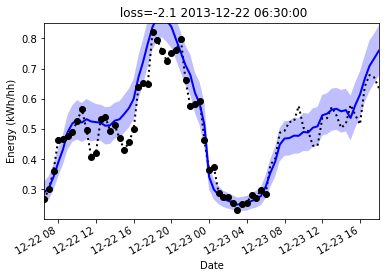

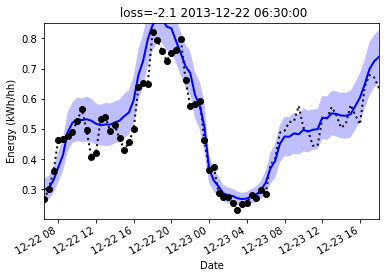

In [18]:
import os
from test_tube import Experiment

model = LatentModelPL(hparams)

# most basic trainer, uses good defaults
trainer = Trainer(
    max_epochs=hparams.max_nb_epochs,
    gpus=hparams.gpus,
    nb_gpu_nodes=hparams.nodes,
    gradient_clip_val=hparams.grad_clip,
)
trainer.fit(model)

AttributeError: 'LatentEncoder' object has no attribute 'self_attention'

In [19]:
hyperparams, hparams = parse_args(f"""
--x_dim {df_train.shape[-1]-1} \
--y_dim 1 \
--grad_clip 40 \
--learning_rate 0.001 \
--latent_dim 32 \
--hidden_dim 32 \
--n_latent_encoder_layers 2 \
--n_det_encoder_layers 2 \
--n_decoder_layers 2 \
--use_lvar True \
--use_deterministic_path True \
--latent_enc_self_attn_type ptmultihead \
--det_enc_self_attn_type ptmultihead \
--det_enc_cross_attn_type ptmultihead \
--attention_layers 2 \
--attention_dropout 0.1 \
--dropout 0.2 \
""")
print(hparams)

----------------------------------------------------------------------------------------------------
Hyperparameters:
gpus                : -1
nodes               : 1
hpc_exp_number      : 1
seed                : 42
evaluate            : False
learning_rate       : 0.001
batch_size          : 16
x_dim               : 16
y_dim               : 1
vis_i               : 670
hidden_dim          : 32
latent_dim          : 32
num_heads           : 8
attention_layers    : 2
n_latent_encoder_layers: 2
n_det_encoder_layers: 2
n_decoder_layers    : 2
dropout             : 0.2
attention_dropout   : 0.1
min_std             : 0.005
latent_enc_self_attn_type: ptmultihead
det_enc_self_attn_type: ptmultihead
det_enc_cross_attn_type: ptmultihead
use_lvar            : True
use_deterministic_path: True
grad_clip           : 40.0
num_context         : 48
num_extra_target    : 24
max_nb_epochs       : 20
num_workers         : 4



INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                          Name           Type Params
0                                        model    LatentModel   61 K
1                        model._latent_encoder  LatentEncoder   16 K
2           model._latent_encoder._input_layer  NPBlockRelu2d  640  
3    model._latent_encoder._input_layer.linear         Linear  576  
4       model._latent_encoder._input_layer.act           ReLU    0  
..                                         ...            ...    ...
142              model._decoder._decoder.1.act           ReLU    0  
143          model._decoder._decoder.1.dropout      Dropout2d    0  
144             model._decoder._decoder.1.norm    BatchNorm2d  192  
145                       model._decoder._mean         Linear   97  
146                        model._decoder._std         Linear   97  

[147 rows x 3 columns]


step 0, {'val_loss': tensor(6439.6782, device='cuda:0'), 'val/kl': tensor(106.3003, device='cuda:0'), 'val/std': tensor(0.0045, device='cuda:0'), 'val/mse': tensor(0.2564, device='cuda:0')}


step 2201, {'val_loss': tensor(-1.0566, device='cuda:0'), 'val/kl': tensor(-0.4806, device='cuda:0'), 'val/std': tensor(0.1785, device='cuda:0'), 'val/mse': tensor(0.0154, device='cuda:0')}


step 4403, {'val_loss': tensor(-1.2789, device='cuda:0'), 'val/kl': tensor(-0.4966, device='cuda:0'), 'val/std': tensor(0.1217, device='cuda:0'), 'val/mse': tensor(0.0140, device='cuda:0')}


step 6605, {'val_loss': tensor(-1.7242, device='cuda:0'), 'val/kl': tensor(-0.4989, device='cuda:0'), 'val/std': tensor(0.0940, device='cuda:0'), 'val/mse': tensor(0.0067, device='cuda:0')}


step 8807, {'val_loss': tensor(-1.8025, device='cuda:0'), 'val/kl': tensor(-0.4975, device='cuda:0'), 'val/std': tensor(0.0826, device='cuda:0'), 'val/mse': tensor(0.0051, device='cuda:0')}


step 11009, {'val_loss': tensor(-1.9245, device='cuda:0'), 'val/kl': tensor(-0.5001, device='cuda:0'), 'val/std': tensor(0.0798, device='cuda:0'), 'val/mse': tensor(0.0035, device='cuda:0')}


step 13211, {'val_loss': tensor(-1.9292, device='cuda:0'), 'val/kl': tensor(-0.4997, device='cuda:0'), 'val/std': tensor(0.0753, device='cuda:0'), 'val/mse': tensor(0.0034, device='cuda:0')}


step 15413, {'val_loss': tensor(-1.9605, device='cuda:0'), 'val/kl': tensor(-0.4963, device='cuda:0'), 'val/std': tensor(0.0749, device='cuda:0'), 'val/mse': tensor(0.0034, device='cuda:0')}


step 17615, {'val_loss': tensor(-1.9655, device='cuda:0'), 'val/kl': tensor(-0.4958, device='cuda:0'), 'val/std': tensor(0.0753, device='cuda:0'), 'val/mse': tensor(0.0033, device='cuda:0')}


step 19817, {'val_loss': tensor(-2.0382, device='cuda:0'), 'val/kl': tensor(-0.4958, device='cuda:0'), 'val/std': tensor(0.0723, device='cuda:0'), 'val/mse': tensor(0.0028, device='cuda:0')}


step 22019, {'val_loss': tensor(-1.9651, device='cuda:0'), 'val/kl': tensor(-0.4961, device='cuda:0'), 'val/std': tensor(0.0787, device='cuda:0'), 'val/mse': tensor(0.0033, device='cuda:0')}


step 24221, {'val_loss': tensor(-1.9327, device='cuda:0'), 'val/kl': tensor(-0.4949, device='cuda:0'), 'val/std': tensor(0.0812, device='cuda:0'), 'val/mse': tensor(0.0034, device='cuda:0')}


step 26423, {'val_loss': tensor(-2.0478, device='cuda:0'), 'val/kl': tensor(-0.5044, device='cuda:0'), 'val/std': tensor(0.0668, device='cuda:0'), 'val/mse': tensor(0.0028, device='cuda:0')}


step 28625, {'val_loss': tensor(-2.0849, device='cuda:0'), 'val/kl': tensor(-0.5042, device='cuda:0'), 'val/std': tensor(0.0638, device='cuda:0'), 'val/mse': tensor(0.0029, device='cuda:0')}


step 30827, {'val_loss': tensor(-2.0682, device='cuda:0'), 'val/kl': tensor(-0.4986, device='cuda:0'), 'val/std': tensor(0.0663, device='cuda:0'), 'val/mse': tensor(0.0031, device='cuda:0')}


step 33029, {'val_loss': tensor(-2.0538, device='cuda:0'), 'val/kl': tensor(-0.4947, device='cuda:0'), 'val/std': tensor(0.0655, device='cuda:0'), 'val/mse': tensor(0.0030, device='cuda:0')}


step 35231, {'val_loss': tensor(-2.0984, device='cuda:0'), 'val/kl': tensor(-0.4935, device='cuda:0'), 'val/std': tensor(0.0587, device='cuda:0'), 'val/mse': tensor(0.0030, device='cuda:0')}


step 37433, {'val_loss': tensor(-2.1404, device='cuda:0'), 'val/kl': tensor(-0.5003, device='cuda:0'), 'val/std': tensor(0.0608, device='cuda:0'), 'val/mse': tensor(0.0026, device='cuda:0')}


step 39635, {'val_loss': tensor(-2.0232, device='cuda:0'), 'val/kl': tensor(-0.5002, device='cuda:0'), 'val/std': tensor(0.0662, device='cuda:0'), 'val/mse': tensor(0.0035, device='cuda:0')}


step 41837, {'val_loss': tensor(-2.1106, device='cuda:0'), 'val/kl': tensor(-0.4926, device='cuda:0'), 'val/std': tensor(0.0651, device='cuda:0'), 'val/mse': tensor(0.0026, device='cuda:0')}


/media/wassname/Storage5/projects2/3ST/attentive-neural-processes/src/plot.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


step 44039, {'val_loss': tensor(-2.0877, device='cuda:0'), 'val/kl': tensor(-0.4943, device='cuda:0'), 'val/std': tensor(0.0603, device='cuda:0'), 'val/mse': tensor(0.0029, device='cuda:0')}
Epoch    19: reducing learning rate of group 0 to 1.0000e-04.



1

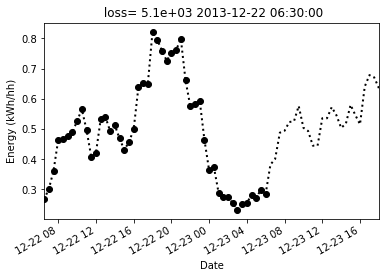

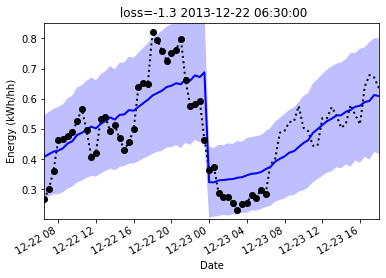

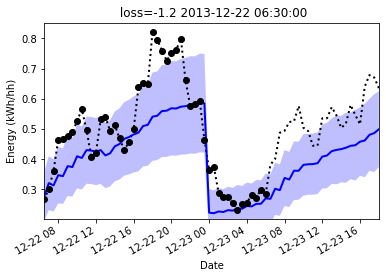

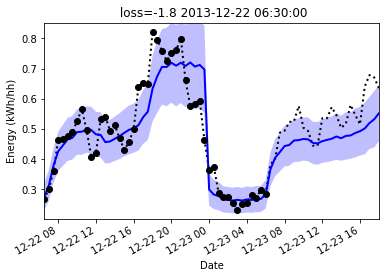

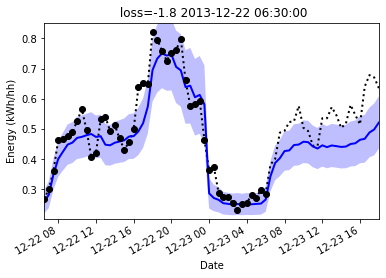

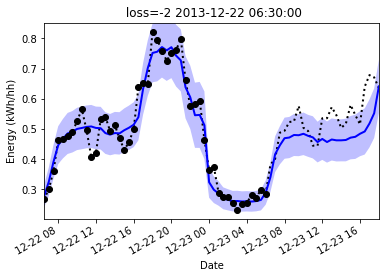

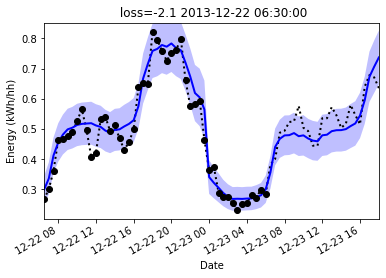

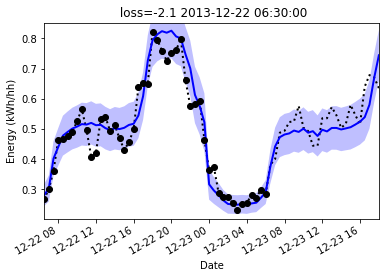

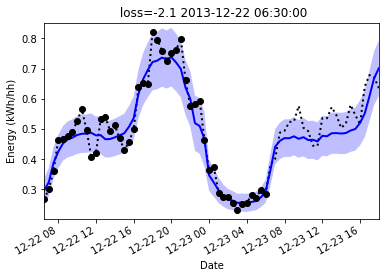

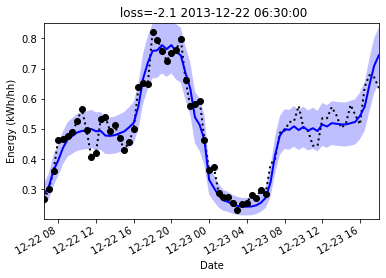

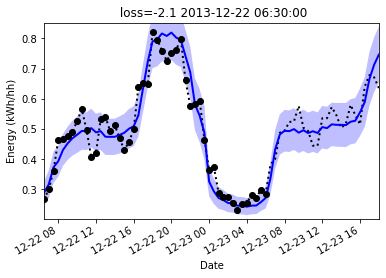

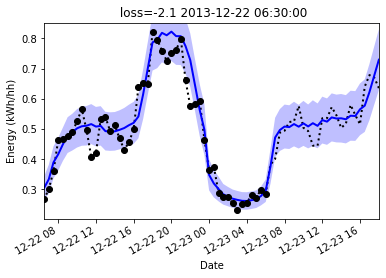

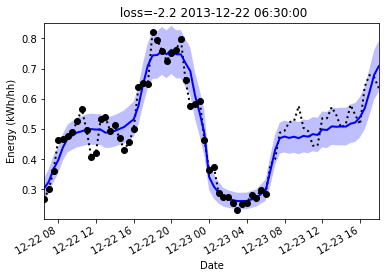

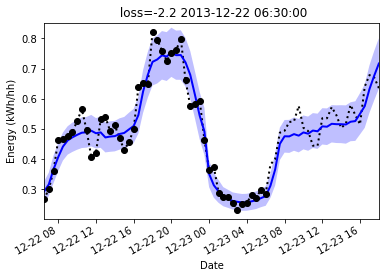

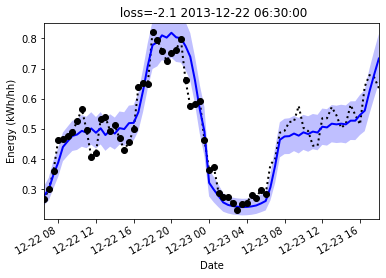

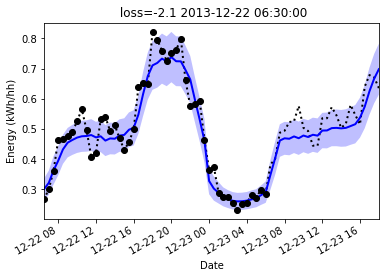

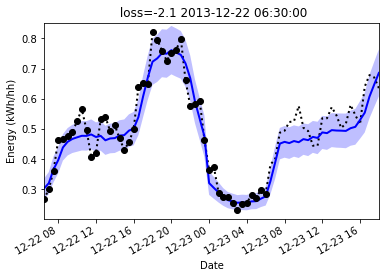

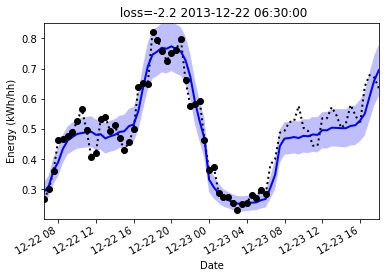

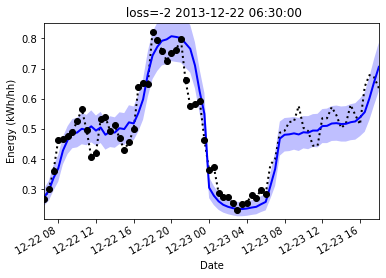

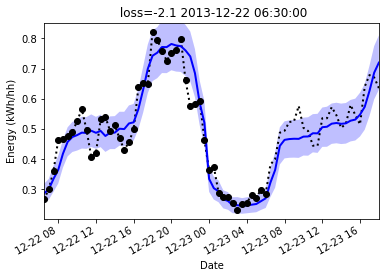

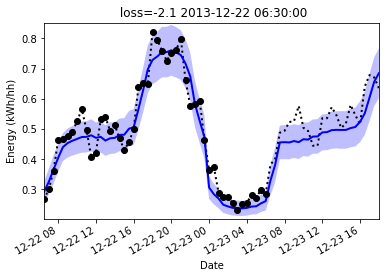

In [20]:
import os
from test_tube import Experiment

model = LatentModelPL(hparams)

# most basic trainer, uses good defaults
trainer = Trainer(
    max_epochs=hparams.max_nb_epochs,
    gpus=hparams.gpus,
    nb_gpu_nodes=hparams.nodes,
    gradient_clip_val=hparams.grad_clip,
)
trainer.fit(model)

In [25]:
print(hparams)

----------------------------------------------------------------------------------------------------
Hyperparameters:
gpus                : -1
nodes               : 1
hpc_exp_number      : 1
seed                : 42
evaluate            : False
learning_rate       : 0.001
batch_size          : 16
x_dim               : 16
y_dim               : 1
vis_i               : 670
hidden_dim          : 32
latent_dim          : 32
num_heads           : 8
attention_layers    : 2
n_latent_encoder_layers: 2
n_det_encoder_layers: 2
n_decoder_layers    : 2
dropout             : 0.2
attention_dropout   : 0.1
min_std             : 0.005
latent_enc_self_attn_type: ptmultihead
det_enc_self_attn_type: ptmultihead
det_enc_cross_attn_type: ptmultihead
use_lvar            : True
use_deterministic_path: True
grad_clip           : 40.0
num_context         : 48
num_extra_target    : 24
max_nb_epochs       : 20
num_workers         : 4



In [27]:
model.logger.log_hyperparams?